# CRNN с датасетом CCPD2019

## Import dependency and data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp -f "/content/drive/MyDrive/Colab Notebooks/kaggle.json" ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download 'romanleo2003/labtinkoff'
! unzip -qq -O utf8 "/content/labtinkoff.zip"

100% 2.12G/2.13G [01:34<00:00, 24.9MB/s]
100% 2.13G/2.13G [01:34<00:00, 24.2MB/s]


In [3]:
! pip install pytorch_lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 800 kB 14.7 MB/s 
     |████████████████████████████████| 512 kB 68.6 MB/s 
     |████████████████████████████████| 125 kB 77.1 MB/s 


In [4]:
import torchvision.transforms as T
import pytorch_lightning as pl
import pandas as pd
import numpy as np
import itertools
import seaborn as sns
import cv2
import torch
import os

from torchmetrics import CharErrorRate
from PIL import Image
from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

sns.set_theme()

In [5]:
BASEPATH = "/content/CCPD2019-dl1"

Посмотрим, какую машину нам выдали

In [6]:
! nvidia-smi

Sun Dec 25 09:39:36 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P0    26W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Создадим условия воиспроизводиомсти

In [7]:
def seed_everything(seed=1234):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    pl.seed_everything(seed)
seed_everything()

INFO:lightning_lite.utilities.seed:Global seed set to 1234


In [8]:
seed_everything()

INFO:lightning_lite.utilities.seed:Global seed set to 1234


## Creating dataset

Посмотрми на элемент выборки, удостоверимся, что все скачалось правильно.

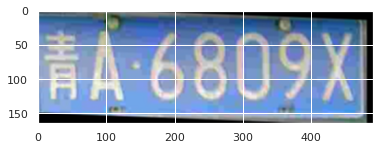

In [51]:
img = Image.open("/content/CCPD2019-dl1/train/0778352490421-青A6809X.jpg")
plt.imshow(T.GaussianBlur(kernel_size=3, sigma=3)(img))

Посмотрим, сколько всего файлов

In [ ]:
! ls -R "/content/CCPD2019-dl1" | wc -l

209986


Опишем датасет

Очевидно, надо будет resize-ить картинки к одному размеру, посмотрим на их размеры

In [ ]:
img_shapes = []
for filename in tqdm(os.listdir("/content/CCPD2019-dl1/test")):
  img_shapes.append(cv2.imread(os.path.join("/content/CCPD2019-dl1/test", filename)).shape)
img_shapes = np.array(img_shapes)

  0%|          | 0/9999 [00:00<?, ?it/s]

(259.4667466746675, 87.41874187418742, 2.9680906074819817)

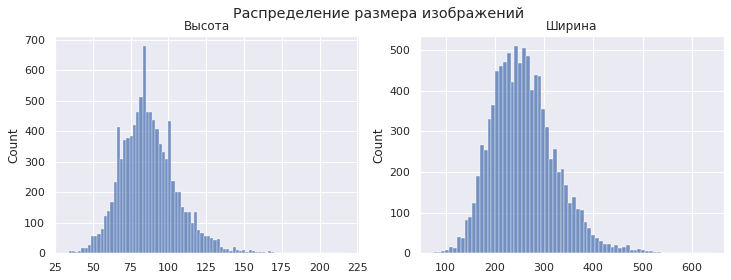

In [ ]:
fig, axs = plt.subplots(1, 2)
fig.suptitle('Распределение размера изображений')
fig.set_size_inches(12, 4)
sns.histplot(img_shapes[:, 0], ax=axs[0]).set(title='Высота')
sns.histplot(img_shapes[:, 1], ax=axs[1]).set(title='Ширина')
img_shapes[:, 1].mean(), img_shapes[:, 0].mean(), img_shapes[:, 1].mean() / img_shapes[:, 0].mean()   

Для сохранения пропроции, надо сжимать картинки так, чтобы отношений их сторон было 1:3 (наверное)

Посчитаем среднее и отклонение для нормализации

In [ ]:
train_dataset = CCPD2019(os.path.join(BASEPATH, "train"))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1)
psum = torch.tensor([0.0, 0.0, 0.0])
psum_sq = torch.tensor([0.0, 0.0, 0.0])

for inputs in tqdm(train_loader):
    psum += inputs[0].sum(axis = [0, 2, 3])
    psum_sq += (inputs[0] ** 2).sum(axis = [0, 2, 3])

count = len(train_loader) * 100 * 32
total_mean = psum / count
total_std = (psum_sq / count - total_mean ** 2) ** 0.5
total_mean, total_std

Создадим словарь конвертации симовлов в индексы и обратно. Для этого я обратился к репозиторию датасета по ссылке из лабораторной работы

In [30]:
provinces = ["皖", "沪", "津", "渝", "冀", "晋", "蒙", "辽", "吉", "黑", "苏", "浙", "京", "闽", "赣", "鲁", "豫", "鄂", "湘", "粤", "桂", "琼", "川", "贵", "云", "藏", "陕", "甘", "青", "宁", "新", "警", "学", 'O']
alphabets = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W',
             'X', 'Y', 'Z', 'O']
ads = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X',
       'Y', 'Z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'O']

In [31]:
letter2index = {j: i for i, j in enumerate(set(provinces + alphabets + ads))}
index2letter = {value: key for key, value in letter2index.items()}

In [89]:
class CCPD2019(torch.utils.data.Dataset):

  def __init__(self, path, to_augmentation=True):
    self.data = []
    self.labels = []
    self.to_augmentation = to_augmentation
    self.resize = T.Resize(size=(32, 128))
    for filename in tqdm(os.listdir(path)):
      self.data.append(os.path.join(path, filename))
      self.labels.append(filename.split("-")[1][:-4])

    self.augmentation_advance = T.Compose([
        T.RandomPerspective(distortion_scale=0.35),
        # T.GaussianBlur(kernel_size=3, sigma=3),
        T.GaussianBlur(kernel_size=3),
        T.RandomRotation(degrees=9)]
    )

    self.augmentation_base = T.Compose([
        T.ToTensor(),
        T.Normalize(mean=[0.2662, 0.4238, 0.6295], std=[0.2352, 0.2473, 0.2816]),
        T.Grayscale()]
    )

  def __len__(self):
    return len(self.data)

  def __getitem__(self, item):
    img = self.resize(Image.open(self.data[item]))
    if self.to_augmentation:
      img = self.augmentation_advance(img)
    return self.augmentation_base(img), [letter2index[i] for i in self.labels[item]]

In [90]:
train_dataset = CCPD2019(os.path.join(BASEPATH, "train"))
test_dataset = CCPD2019(os.path.join(BASEPATH, "test"), False)
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [0.9, 0.1], generator=torch.Generator().manual_seed(1234))
len(train_dataset), len(val_dataset)

  0%|          | 0/199980 [00:00<?, ?it/s]

  0%|          | 0/9999 [00:00<?, ?it/s]

(179982, 19998)

## Creating Model

In [34]:
class BidirectionalLSTM(torch.nn.Module):
  def __init__(self, in_size, out_size):
    super(BidirectionalLSTM, self).__init__()
    self.lstm = torch.nn.LSTM(in_size, out_size, bidirectional=True, batch_first=True)
    self.head_lstm =torch.nn.Linear(out_size * 2, out_size)

  def forward(self, X):
    predict, _ = self.lstm(X)
    predict = self.head_lstm(predict)
    return predict

In [111]:
class CRNN(torch.nn.Module):
  def __init__(self):
    super(CRNN, self).__init__()
    self.convolution_part = torch.nn.Sequential(
        torch.nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, bias=False),
        torch.nn.BatchNorm2d(64),
        torch.nn.MaxPool2d(2, 2),
        torch.nn.Conv2d(64, 128, 3, 1, 1, bias=False),
        torch.nn.BatchNorm2d(128),
        torch.nn.MaxPool2d(2, 2),
        torch.nn.Conv2d(128, 256, 3, 1, 1, bias=False),
        torch.nn.BatchNorm2d(256),
        torch.nn.Conv2d(256, 256, 3, 1, 1, bias=False),
        torch.nn.BatchNorm2d(256),
        torch.nn.MaxPool2d((1, 2), 2),
        torch.nn.Conv2d(256, 512, 3, 1, 1, bias=False),
        torch.nn.BatchNorm2d(512),
        torch.nn.Conv2d(512, 512, 3, 1, 1, bias=False),
        torch.nn.BatchNorm2d(512),
        torch.nn.MaxPool2d((1, 2), (2, 1)),
        torch.nn.Conv2d(512, 512, 2, (1, 2), 0, bias=False),
        torch.nn.BatchNorm2d(512),
    )

    self.lstm = torch.nn.Sequential(
        BidirectionalLSTM(512, 256),
        torch.nn.Dropout(0.5),
        BidirectionalLSTM(256, 256)
    )
    
    self.dropout2 = torch.nn.Dropout(p=0.5)
    self.clsf_head = torch.nn.Linear(256, len(letter2index))

  def forward(self, X):
    predict = self.convolution_part(X)
    predict = predict.permute(0, 3, 1, 2).squeeze(3)
    predict = self.lstm(predict)
    predict = self.dropout2(predict)
    predict = self.clsf_head(predict)
    return predict

## Training

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir logs/

In [124]:
def simple_decoder(y):
  output = []
  for i in y:
    output.append("".join(map(lambda x: index2letter[x.item()], i)))
  return output

In [123]:
wrong_img_df = pd.DataFrame([])
def print_wrong_val(y_hat, y):
  wrong_img = dict({i: j for i, j in zip(y, y_hat) if i != j})
  true, predicted = list(wrong_img.keys()), list(wrong_img.values())
  global wrong_img_df
  wrong_img_df = pd.DataFrame([])
  wrong_img_df["true"] = true
  wrong_img_df["predicted"] = predicted
  print(wrong_img_df)

In [39]:
def accuracy(y_hat, y):
  return sum([i == j for i, j in zip(y_hat, y)]) / len(y)

In [91]:
class TrainCCPD(pl.LightningModule):
  def __init__(self, model, learning_rate=1e-3):
    super().__init__()
    self.model = model
    self.ce_loss = torch.nn.CrossEntropyLoss()
    self.cer_metric = CharErrorRate()
    self.learning_rate = learning_rate
  
  def training_step(self, batch, batch_idx):
    X, y = batch
    y_hat = self.model(X)
    y = torch.stack(y, axis=1)
    loss = 0
    for i in range(y_hat.shape[1]):
        loss += self.ce_loss(y_hat[:, i, :], y[:, i])
    self.log("loss", loss)
    return {"loss": loss}

  def test_step(self, batch, batch_idx):
    X, y = batch
    y_hat = model(X)
    pred2str = simple_decoder(torch.argmax(y_hat.cpu(), 2))
    y2str = simple_decoder(torch.stack(y, axis=1).cpu())
    return {"preds": pred2str, "targets": y2str}

  def test_epoch_end(self, outputs) -> None:
    preds = list(itertools.chain(*[b["preds"] for b in outputs]))
    targets = list(itertools.chain(*[b["targets"]for b in outputs]))
    print_wrong_val(preds, targets)
    self.log("test_accuracy", accuracy(targets, preds))
    self.log("test_cer", self.cer_metric(targets, preds))

  def validation_step(self, batch, batch_idx):
    return self.test_step(batch, batch_idx)

  def validation_epoch_end(self, outputs) -> None:
    preds = list(itertools.chain(*[b["preds"] for b in outputs]))
    targets = list(itertools.chain(*[b["targets"] for b in outputs]))
    self.log("val_accuracy", accuracy(targets, preds))
    self.log("val_cer", self.cer_metric(targets, preds))

  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
    return optimizer

### GaussianBlur with sigma = 0

In [96]:
model = CRNN()

In [97]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, 16)
test_dataloader = torch.utils.data.DataLoader(test_dataset, 16)
val_dataloader = torch.utils.data.DataLoader(val_dataset, 16)

In [ ]:
module = TrainCCPD(model)
logger = pl.loggers.TensorBoardLogger("./logs", name='ce')
trainer = pl.Trainer(
    accelerator="gpu",
    logger=logger,
    log_every_n_steps=10,
    max_epochs=20,
)
trainer.fit(module, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

In [108]:
trainer.test(model=module, dataloaders=test_dataloader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

        true predicted
0    皖AJ915C   皖A491GE
1    鲁Q6099K   浙Q6099K
2    黑AK556M   皖AK556M
3    湘A7304H   豫A7304H
4    皖A98676   皖A996Z6
..       ...       ...
535  云AFQ958   皖AFQ958
536  京N659Y7   苏N659Y7
537  皖A22CB2   皖A22C82
538  皖A8S375   皖A85375
539  皖AM444M   皖AM343M

[540 rows x 2 columns]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.9445944428443909
        test_cer           0.009286643005907536
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_accuracy': 0.9445944428443909, 'test_cer': 0.009286643005907536}]

In [109]:
torch.save(model.state_dict(), "model.pt")

### GaussianBlur with sigma != 0

In [55]:
model = CRNN()

In [56]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, 16)
test_dataloader = torch.utils.data.DataLoader(test_dataset, 16)
val_dataloader = torch.utils.data.DataLoader(val_dataset, 16)

In [57]:
module = TrainCCPD(model)
logger = pl.loggers.TensorBoardLogger("./logs", name='ce')
trainer = pl.Trainer(
    accelerator="gpu",
    logger=logger,
    log_every_n_steps=10,
    max_epochs=20,
)
trainer.fit(module, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type             | Params
------------------------------------------------
0 | model      | CRNN             | 8.5 M 
1 | ce_loss    | CrossEntropyLoss | 0     
2 | cer_metric | CharErrorRate    | 0     
------------------------------------------------
8.5 M     Trainable params
0         Non-trainable params
8.5 M     Total params
33.843    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [59]:
trainer.test(model=module, dataloaders=test_dataloader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

        true predicted
0    皖AJ915C   皖A4916C
1    皖AZJ159   皖AZJ15S
2    皖ACF358   苏ACF358
3    皖AWZ160   苏AWZ160
4    皖A6U829   皖A60829
..       ...       ...
880  豫HQ7131   闽HQ7131
881  云AFQ958   6AFQ958
882  京N659Y7   苏N659Y7
883  皖A22CB2   浙A22CB2
884  皖Q18245   闽Q18245

[885 rows x 2 columns]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.9096909761428833
        test_cer           0.015058648772537708
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_accuracy': 0.9096909761428833, 'test_cer': 0.015058648772537708}]

In [101]:
torch.save(model.state_dict(), "model.pt")

## Self - reflection

**Начало** </br>
Первым делом передо мной встал вопрос создания датасета: загрузить весь датасет в память, что уменьшит время одной эпохи, либо подгружать изображения по мере необходимости. После нескольких попыток я пришел к выводу, что система крайне не устойчива, если в нее загружать весь датасет, поэтому я остановился на втором варианте.


---


**Выбор модели** </br>
В качестве скелета модели я выбрал структуру из оригинальной [статьи про сверточно-рекурентные нейронные сети](https://arxiv.org/pdf/1507.05717.pdf), однако я также добавил батч-нормализацию после каждого сверточного слоя. Помимо этого я изменил несколько конечных сверточных слоев, чтобы после их применения латентный слой был размера [512, 1, 7] (гос. номер состоит из 7 знаков). Также я добавил 2 dropout-a что заметно улучшило качество модели.


---


**Обучение**</br>
Pipeline я решил организовывать с помощью pytorch lightning, так как это <s>стильно, модно, молодежно</s> удобно, быстро, информативно (удобные графики в tenserboard), а также необычно, так как писать обвчный training loop довольно уныло. В качестве функции потерь я использовал обычную кросс энтропию. В качестве оптимизаторов я пробовал использовать Adam (так как почти серебряная пуля), Adelta (так как в оригинальной статье использовали его) и SGD Momentum, но для него мне не удалось подобрать нужный lr. Из интересного - автоподбор lr с помощью trainer-a из pytorch lightning у меня не отработал корректно, обучение с ним дало результаты ниже, нежели без него. 

---

**Анализ**</br>
После этого я долго экспериментировал с параметрами аугментации, пытался добавить dropout между двумя lstm, пробовал изменить параметры входного изображения и т.д. В итоге остановился на том, что вы видите выше. Из всех экспериментов я оставил, только изменение параметры Гауссовго шума. Так как при анализе изображений, текст с которых был неверно распознан, я нашел 0650-皖AK8C86.jpg. Она мне показалась достаточно нечеткой, поэтому меня посетила мысль специально размыливать входные изображения с помощью шума Гаусса. Однако это не только не увеличило качество, но и снизило его.

 Также я обратил внимание, что во многих кейсах неправильно распознается именно первый символ - иероглиф (тут я не виню модель, я сам их плохо различаю, но все же). Также я посмотрел я распределеие иероглифов, которые модель предсказала неверно.

Первое, что я заметил - его не равномерность, второе наблюдение - неправильные предсказания модели зависят от начертания иероглифа. Всего предсказано неверно +- 554 lable-a. Из них 193 - из-за первого иероглифа. А это +- 35%. 

Также имеют место случаи, когда модель путает похожие символы - 0 и D, и тому подобные, но на это уже нельзя оказать значимый эффект.


---


**Предложения**</br>
На мой взгляд самым очевидным решением по улучшению качества - сбалансировать датасет, но так как это не всегда возможно - использовать веса в функции потерь. Это должно дать прирост. Также возможно подобрать lr для sgd momentum, это может положительно сказаться на модели. И последнее, на мой взгляд, самое радикальное - пересмотреть структуру сверточной части. При текущей реализации модели хватает +- 30 минут для достижения неплохого качества, поэтому почему бы и нет.

In [ ]:
! ls /content/CCPD2019-dl1/test/ | egrep "皖AK8C86"

0650-皖AK8C86.jpg


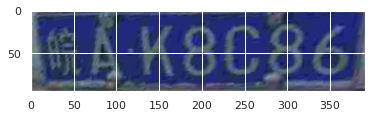

In [ ]:
img = Image.open("/content/CCPD2019-dl1/test/0650-皖AK8C86.jpg")
plt.imshow(img)

In [ ]:
letters = {}

In [ ]:
for filename in tqdm(os.listdir(os.path.join(BASEPATH, "train"))):
  letter = filename.split("-")[1][0]
  if letter in letters:
    letters[letter] += 1
  else:
    letters[letter] = 1


  0%|          | 0/199980 [00:00<?, ?it/s]

In [ ]:
sorted(letters.items(), key=lambda x:x[1], reverse=True)

[('皖', 191796),
 ('苏', 3311),
 ('浙', 1349),
 ('沪', 663),
 ('豫', 431),
 ('粤', 373),
 ('京', 307),
 ('鄂', 278),
 ('鲁', 248),
 ('闽', 208),
 ('冀', 175),
 ('赣', 151),
 ('川', 121),
 ('湘', 96),
 ('渝', 74),
 ('晋', 67),
 ('津', 60),
 ('辽', 59),
 ('陕', 55),
 ('蒙', 19),
 ('黑', 18),
 ('甘', 18),
 ('云', 17),
 ('贵', 16),
 ('新', 16),
 ('桂', 15),
 ('吉', 13),
 ('青', 11),
 ('琼', 9),
 ('宁', 5),
 ('藏', 1)]

In [122]:
wrong_img_df[wrong_img_df["true"].apply(lambda x : x[0]) != wrong_img_df["predicted"].apply(lambda x : x[0])]["true"].apply(lambda x : x[0]).value_counts()

浙    21
苏    20
鄂    20
粤    20
豫    16
京    14
鲁    11
赣     9
沪     5
蒙     5
陕     5
湘     5
闽     4
冀     4
辽     4
皖     4
津     4
黑     3
新     3
渝     3
晋     3
云     2
贵     2
甘     1
青     1
川     1
琼     1
宁     1
吉     1
Name: true, dtype: int64